#ENTREGABLE GRUPO 16
##INTEGRANTES:
Fernanda Borghello, Rodrigo Ruiz, Alfonsina Szpeiner
###[TP4: kaggle Competition](https://www.kaggle.com/competitions/spaceship-titanic/data)

### Presentamos los códigos creados para obtener el mayor puntaje obtenido en Kaggle (0.80229)



### Importamos librerias

In [ ]:
#Analisis y visualizacion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocesamiento
import missingno as msno
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

#Modelos
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,ParameterGrid
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRegressor, XGBRFRegressor, XGBClassifier, XGBRFClassifier

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def connect_to_drive():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_csv(filename)

drive = connect_to_drive()

### Importamos la base de datos

In [ ]:
df_base = read_csv_from_drive(drive, '1_vSiiOm7-_uVBGkhYJLG38ranH-F6nTm' , 'train.csv')

## Análisis y visualización

<font color='darkblue'><strong>
1. Observamos analiticamente la información del dataset

In [ ]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   7823 non-null   int64  
 1   HomePlanet    7644 non-null   object 
 2   CryoSleep     7627 non-null   object 
 3   Cabin         7639 non-null   object 
 4   Destination   7663 non-null   object 
 5   Age           7661 non-null   float64
 6   VIP           7639 non-null   object 
 7   RoomService   7669 non-null   float64
 8   FoodCourt     7668 non-null   float64
 9   ShoppingMall  7635 non-null   float64
 10  Spa           7665 non-null   float64
 11  VRDeck        7654 non-null   float64
 12  Name          7639 non-null   object 
 13  Transported   7823 non-null   int64  
dtypes: float64(6), int64(2), object(6)
memory usage: 855.8+ KB


<font color='darkblue'><strong>
2. Sacamos la variable "Name" que entendemos no aporta información relevante

In [ ]:
df1=df_base.drop('Name',axis=1)
df1

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,3430,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,0
1,669,Mars,True,F/126/S,NaN,18.0,False,0.0,0.0,0.0,0.0,0.0,1
2,8430,Europa,True,B/343/S,TRAPPIST-1e,33.0,NaN,0.0,0.0,0.0,0.0,0.0,1
3,6463,Earth,False,F/1420/P,TRAPPIST-1e,43.0,False,142.0,1208.0,0.0,0.0,204.0,0
4,85,Earth,False,G/9/P,TRAPPIST-1e,19.0,False,0.0,0.0,670.0,1.0,34.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7818,6528,Mars,False,F/1319/S,TRAPPIST-1e,12.0,NaN,0.0,0.0,0.0,0.0,0.0,1
7819,2693,Earth,False,G/459/S,TRAPPIST-1e,44.0,False,0.0,0.0,744.0,62.0,3.0,0
7820,8076,Mars,True,F/1772/P,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,1
7821,3829,Earth,False,E/253/P,TRAPPIST-1e,15.0,False,0.0,840.0,123.0,0.0,20.0,0


<font color='darkblue'><strong>
3. Observamos analìticamente  la cantidad de datos nulos en cada columna

In [ ]:
df_base.isnull().sum()

PassengerId       0
HomePlanet      179
CryoSleep       196
Cabin           184
Destination     160
Age             162
VIP             184
RoomService     154
FoodCourt       155
ShoppingMall    188
Spa             158
VRDeck          169
Name            184
Transported       0
dtype: int64

<font color='darkblue'><strong>
4. En lo observado anteriormente, podemos detectar que los datos nulos no coinciden en las filas, por lo que decidimos no borrarlos ya que estarariamos eliminando una cantidad significativa de filas y procedemos a imputarlos. Utilizamos Simple Imputer e imputamos por "most_frequent" para poder imputar variables numericas como categóricas.

In [ ]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService", "HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP" ]
imputer = SimpleImputer(strategy="most_frequent")
df1[imputer_cols] = imputer.fit_transform(df1[imputer_cols])

In [ ]:
df1.sample(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
4372,3628,Earth,True,G/636/P,55 Cancri e,7.0,False,0.0,0.0,0.0,0.0,0.0,1
7516,6829,Europa,False,B/271/S,TRAPPIST-1e,53.0,False,0.0,0.0,0.0,0.0,0.0,1
7476,494,Mars,False,D/21/P,TRAPPIST-1e,33.0,False,20.0,0.0,384.0,557.0,0.0,0
3163,1026,Mars,True,F/223/P,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,0.0,0.0,1
5144,5778,Europa,False,C/229/S,TRAPPIST-1e,28.0,False,0.0,4585.0,0.0,2.0,35.0,1
5646,84,Earth,False,F/20/S,TRAPPIST-1e,27.0,False,1.0,697.0,31.0,188.0,0.0,0
892,7657,Earth,False,G/1316/S,TRAPPIST-1e,22.0,False,753.0,0.0,0.0,0.0,0.0,0
3682,6709,Earth,False,E/473/S,TRAPPIST-1e,44.0,False,143.0,47.0,0.0,717.0,87.0,0
3601,5658,Earth,False,G/973/P,TRAPPIST-1e,20.0,False,3.0,0.0,0.0,806.0,0.0,0
6344,7569,Earth,False,F/1671/P,TRAPPIST-1e,19.0,False,0.0,0.0,1761.0,0.0,36.0,1


## Transformaciones

In [ ]:
df = df1.copy(deep=True)

<font color='darkblue'><strong>
5. Observamos analìticamente  la cantidad de datos únicos en cada columna categórica

In [ ]:
df[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']].nunique()

HomePlanet        3
CryoSleep         2
Cabin          6009
Destination       3
VIP               2
dtype: int64

<font color='darkblue'><strong>
6 . Dada la gran cantidad de datos únicos, se decide la creacion de 3 columnas a partir de la columna 'cabin'

In [ ]:
df[['cabin_deck','cabin_num','cabin_side']] = df['Cabin'].str.split('/', expand=True)
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_deck,cabin_num,cabin_side
0,3430,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,0,C,123,P
1,669,Mars,True,F/126/S,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,0.0,1,F,126,S
2,8430,Europa,True,B/343/S,TRAPPIST-1e,33.0,False,0.0,0.0,0.0,0.0,0.0,1,B,343,S
3,6463,Earth,False,F/1420/P,TRAPPIST-1e,43.0,False,142.0,1208.0,0.0,0.0,204.0,0,F,1420,P
4,85,Earth,False,G/9/P,TRAPPIST-1e,19.0,False,0.0,0.0,670.0,1.0,34.0,0,G,9,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7818,6528,Mars,False,F/1319/S,TRAPPIST-1e,12.0,False,0.0,0.0,0.0,0.0,0.0,1,F,1319,S
7819,2693,Earth,False,G/459/S,TRAPPIST-1e,44.0,False,0.0,0.0,744.0,62.0,3.0,0,G,459,S
7820,8076,Mars,True,F/1772/P,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,1,F,1772,P
7821,3829,Earth,False,E/253/P,TRAPPIST-1e,15.0,False,0.0,840.0,123.0,0.0,20.0,0,E,253,P


<font color='darkblue'><strong>
7. Dado que hemos creado tres nuevas variables para Cabin, sacamos la "original"

In [ ]:
df1=df.drop('Cabin',axis=1)
df1

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_deck,cabin_num,cabin_side
0,3430,Europa,False,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,0,C,123,P
1,669,Mars,True,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,0.0,1,F,126,S
2,8430,Europa,True,TRAPPIST-1e,33.0,False,0.0,0.0,0.0,0.0,0.0,1,B,343,S
3,6463,Earth,False,TRAPPIST-1e,43.0,False,142.0,1208.0,0.0,0.0,204.0,0,F,1420,P
4,85,Earth,False,TRAPPIST-1e,19.0,False,0.0,0.0,670.0,1.0,34.0,0,G,9,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7818,6528,Mars,False,TRAPPIST-1e,12.0,False,0.0,0.0,0.0,0.0,0.0,1,F,1319,S
7819,2693,Earth,False,TRAPPIST-1e,44.0,False,0.0,0.0,744.0,62.0,3.0,0,G,459,S
7820,8076,Mars,True,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,1,F,1772,P
7821,3829,Earth,False,TRAPPIST-1e,15.0,False,0.0,840.0,123.0,0.0,20.0,0,E,253,P


<font color='darkblue'><strong>
8. Observamos analìticamente  la cantidad de datos nulos en cada columna y el nuevo dataset obtenido

In [ ]:
df.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
cabin_deck      0
cabin_num       0
cabin_side      0
dtype: int64

<font color='darkblue'><strong>
9. Observamos analíticamente  el nuevo dataset obtenido y separamos la variable "target" (Y="transported") del resto del dataset (X) para poder aplicar transformaciones a X

In [ ]:
print(df1.shape)
print(df1.describe())
Y = df1.Transported
X = df1.drop('Transported',axis=1)
X

(7823, 15)
       PassengerId  Transported
count  7823.000000  7823.000000
mean   4345.691039     0.506711
std    2504.576803     0.499987
min       0.000000     0.000000
25%    2182.500000     0.000000
50%    4345.000000     1.000000
75%    6515.500000     1.000000
max    8692.000000     1.000000


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_deck,cabin_num,cabin_side
0,3430,Europa,False,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,C,123,P
1,669,Mars,True,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,0.0,F,126,S
2,8430,Europa,True,TRAPPIST-1e,33.0,False,0.0,0.0,0.0,0.0,0.0,B,343,S
3,6463,Earth,False,TRAPPIST-1e,43.0,False,142.0,1208.0,0.0,0.0,204.0,F,1420,P
4,85,Earth,False,TRAPPIST-1e,19.0,False,0.0,0.0,670.0,1.0,34.0,G,9,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7818,6528,Mars,False,TRAPPIST-1e,12.0,False,0.0,0.0,0.0,0.0,0.0,F,1319,S
7819,2693,Earth,False,TRAPPIST-1e,44.0,False,0.0,0.0,744.0,62.0,3.0,G,459,S
7820,8076,Mars,True,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,F,1772,P
7821,3829,Earth,False,TRAPPIST-1e,15.0,False,0.0,840.0,123.0,0.0,20.0,E,253,P


<font color='darkblue'><strong>
10. Aplicamos OneHotEnconding en todas las variables categóricas: "CryoSleep", "VIP", "Destination", "cabin_deck", "cabin_side" y "HomePlanet".

In [ ]:
df_dummies = pd.get_dummies(df[['CryoSleep', 'VIP', 'cabin_deck', 'cabin_side',
            'HomePlanet', 'Destination']], prefix=['CryoSleep', 'VIP', 'cabin_deck', 'cabin_side',
            'HomePlanet', 'Destination'], prefix_sep='_', dummy_na=False, sparse=False)
dummies_cols = list(df_dummies.columns)
df_dummies.head(5)

,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,cabin_deck_A,cabin_deck_B,cabin_deck_C,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_T,cabin_side_P,cabin_side_S,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
2,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1
3,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1
4,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1


<font color='darkblue'><strong>
11. Agregamos las columnas de los encodings al DF original y quitamos las categoricas que han sido reemplazadas

In [ ]:
X2 = pd.concat([X,df_dummies], axis=1)
X2 = X2.drop(['HomePlanet','CryoSleep','VIP','Destination', 'cabin_deck', 'cabin_side'], axis=1)
X2.head(5)

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_num,CryoSleep_False,CryoSleep_True,...,cabin_deck_G,cabin_deck_T,cabin_side_P,cabin_side_S,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,3430,57.0,0.0,3859.0,13.0,195.0,3874.0,123,1,0,...,0,0,1,0,0,1,0,0,0,1
1,669,18.0,0.0,0.0,0.0,0.0,0.0,126,0,1,...,0,0,0,1,0,0,1,0,0,1
2,8430,33.0,0.0,0.0,0.0,0.0,0.0,343,0,1,...,0,0,0,1,0,1,0,0,0,1
3,6463,43.0,142.0,1208.0,0.0,0.0,204.0,1420,1,0,...,0,0,1,0,1,0,0,0,0,1
4,85,19.0,0.0,0.0,670.0,1.0,34.0,9,1,0,...,1,0,1,0,1,0,0,0,0,1


<font color='darkblue'><strong>
12. Observamos analíticamente  el nuevo dataset obtenido

In [ ]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   PassengerId                7823 non-null   int64 
 1   Age                        7823 non-null   object
 2   RoomService                7823 non-null   object
 3   FoodCourt                  7823 non-null   object
 4   ShoppingMall               7823 non-null   object
 5   Spa                        7823 non-null   object
 6   VRDeck                     7823 non-null   object
 7   cabin_num                  7823 non-null   object
 8   CryoSleep_False            7823 non-null   uint8 
 9   CryoSleep_True             7823 non-null   uint8 
 10  VIP_False                  7823 non-null   uint8 
 11  VIP_True                   7823 non-null   uint8 
 12  cabin_deck_A               7823 non-null   uint8 
 13  cabin_deck_B               7823 non-null   uint8 
 14  cabin_de

<font color='darkblue'><strong>
13. Cambiamos el tipo de variable para que todas sean "int64"

In [ ]:
X2.astype('int64').dtypes

PassengerId                  int64
Age                          int64
RoomService                  int64
FoodCourt                    int64
ShoppingMall                 int64
Spa                          int64
VRDeck                       int64
cabin_num                    int64
CryoSleep_False              int64
CryoSleep_True               int64
VIP_False                    int64
VIP_True                     int64
cabin_deck_A                 int64
cabin_deck_B                 int64
cabin_deck_C                 int64
cabin_deck_D                 int64
cabin_deck_E                 int64
cabin_deck_F                 int64
cabin_deck_G                 int64
cabin_deck_T                 int64
cabin_side_P                 int64
cabin_side_S                 int64
HomePlanet_Earth             int64
HomePlanet_Europa            int64
HomePlanet_Mars              int64
Destination_55 Cancri e      int64
Destination_PSO J318.5-22    int64
Destination_TRAPPIST-1e      int64
dtype: object

###Escalado 

<font color='darkblue'><strong>
14. Se procede a escalar el dataset a un rango de 0/1 excepto las variables dummies que ya tienen ese rango. Se utiliza el MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
df_to_scld = X2.copy(deep=True)
df_scld = scaler.fit_transform(df_to_scld)
df_scld = pd.DataFrame(df_scld, columns=df_to_scld.columns)
df_scld.sample(5)

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_num,CryoSleep_False,CryoSleep_True,...,cabin_deck_G,cabin_deck_T,cabin_side_P,cabin_side_S,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
4407,0.718017,0.316456,0.004746,0.000000,0.1575,0.000000,0.000000,0.109878,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4025,0.999885,0.405063,0.000000,0.035186,0.0000,0.015753,0.134049,0.321183,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1414,0.348251,0.354430,0.000000,0.000000,0.0000,0.000000,0.000000,0.064976,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1044,0.460884,0.227848,0.000000,0.000000,0.0000,0.000000,0.000000,0.368199,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
6174,0.912103,0.772152,0.000000,0.000000,0.0000,0.000000,0.000000,0.917063,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


<font color='darkblue'><strong>
15. Observamos analiticamente el nuevo dataset obtenido.

In [ ]:
df_scld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                7823 non-null   float64
 1   Age                        7823 non-null   float64
 2   RoomService                7823 non-null   float64
 3   FoodCourt                  7823 non-null   float64
 4   ShoppingMall               7823 non-null   float64
 5   Spa                        7823 non-null   float64
 6   VRDeck                     7823 non-null   float64
 7   cabin_num                  7823 non-null   float64
 8   CryoSleep_False            7823 non-null   float64
 9   CryoSleep_True             7823 non-null   float64
 10  VIP_False                  7823 non-null   float64
 11  VIP_True                   7823 non-null   float64
 12  cabin_deck_A               7823 non-null   float64
 13  cabin_deck_B               7823 non-null   float

<font color='darkblue'><strong>
16. Se procede a volver a definir X incorporando los datos ya escalados. 

In [ ]:
Y = df.Transported
X = df_scld
Y

0       0
1       1
2       1
3       0
4       0
       ..
7818    1
7819    0
7820    1
7821    0
7822    1
Name: Transported, Length: 7823, dtype: int64

<font color='darkblue'><strong>
17. Se procede a dividir el dataset entre set de entrenamiento y test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state = 0)

## Planteamos modelos


In [ ]:
clfs = [
    KNeighborsClassifier(),
    SVC(kernel="linear", random_state=0),
    SVC(gamma=1, C=1, random_state=0),
    LogisticRegression(max_iter=200, random_state=0),
    SGDClassifier(random_state=0),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
    MLPClassifier(max_iter=1000, random_state=0)
]
names = [
    'Nearest Neighbors',
    'Linear SVM',
    'Radial Basis Function SVM',
    'Logistic Regression',
    'SGD Classifier',
    'Decision Tree',
    'Random Forest',
    'Gradient Boosting Classifier',
    'Multi-layer Perceptron (Neural Net)'
]

trained_models = []
accuracy_models = []
for clf,name in zip(clfs,names):
    print(name)
    clf.fit(x_train, y_train)
    train_predictions = clf.predict(x_train)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    test_predictions = clf.predict(x_test)
    accuracy = accuracy_score(y_test, test_predictions)
    print(f"Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    # plot_confusion_matrix(clf,x_test,y_test)
    trained_models.append(clf)
    accuracy_models.append(accuracy*100)
    print('-'*40)

Nearest Neighbors
Accuracy train Nearest Neighbors: 82.73%
Accuracy test Nearest Neighbors: 73.10%
----------------------------------------
Linear SVM
Accuracy train Linear SVM: 75.49%
Accuracy test Linear SVM: 75.97%
----------------------------------------
Radial Basis Function SVM
Accuracy train Radial Basis Function SVM: 76.86%
Accuracy test Radial Basis Function SVM: 75.34%
----------------------------------------
Logistic Regression
Accuracy train Logistic Regression: 76.59%
Accuracy test Logistic Regression: 77.12%
----------------------------------------
SGD Classifier
Accuracy train SGD Classifier: 75.87%
Accuracy test SGD Classifier: 76.10%
----------------------------------------
Decision Tree
Accuracy train Decision Tree: 100.00%
Accuracy test Decision Tree: 75.21%
----------------------------------------
Random Forest
Accuracy train Random Forest: 100.00%
Accuracy test Random Forest: 80.51%
----------------------------------------
Gradient Boosting Classifier
Accuracy trai

<font color='darkblue'><strong>
18. Analizando los Accuracy obtenidos con los distintos modelos, decidimos proceder a realizar el ajuste de hiperparámetros con los 3 modelos que presentan un mayor valor: RANDOM FOREST,  GRADIENT BOOSTING CLASSIFIER y MULTI-LAYER PERCEPTON

### MODELO 1: Ajuste de hiperparámetros: Random Forest

<font color='darkblue'><strong>
Analizamos los mejores parametros para el modelo (Usamos muchas alternativas, dejamos esta mas simple que tarda unos minutos en correr porque sino tardaría varias horas en converger!)

In [ ]:
param_grid = {'n_estimators': [100],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20]
                }
modelo = RandomForestClassifier(random_state=0)
grid = GridSearchCV(modelo, param_grid)
grid.fit(x_train,y_train)
grid.best_params_

{'max_depth': 10, 'max_features': 5, 'n_estimators': 100}

<font color='darkblue'><strong>
Aplicamos los mejores parametros y obtenemos la accurancy y la matriz de Confusion

Accuracy train Random Forest: 88.16%
Accuracy test Random Forest: 80.13%


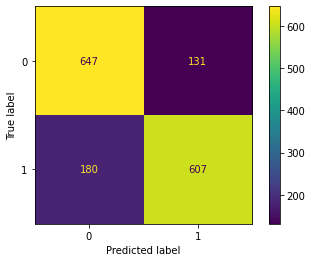

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       778
           1       0.82      0.77      0.80       787

    accuracy                           0.80      1565
   macro avg       0.80      0.80      0.80      1565
weighted avg       0.80      0.80      0.80      1565



In [ ]:
RDF = RandomForestClassifier(**grid.best_params_).fit(x_train, y_train)

train_predictions = RDF.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Random Forest: %.2f%%" % (accuracy * 100.0))

test_predictions = RDF.predict(x_test)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test Random Forest: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

print(classification_report(y_test,RDF.predict(x_test)))

## Modelo 2: Ajuste de hiperparámetros: Multi-layer Perceptron (Neural Net) ( corre en 1hs aprox)

In [ ]:
param_grid_mlp = {'activation': ['tanh', 'relu'], #Función de activación para la capa oculta.
              'solver'   : [ 'sgd', 'adam'], #determina el optimizador a utilizar
              'alpha': [0.0001, 0.05], #Parámetro de penalización L2
              'learning_rate': ['constant','adaptive'], #Programación de la tasa de aprendizaje
                }
modelo = MLPClassifier(max_iter=3000, random_state=0)
print(f'Combinaciones posibles: {len(ParameterGrid(param_grid_mlp))}')
grid = GridSearchCV(modelo, param_grid_mlp)
grid.fit(x_train,y_train)
best_mlp = grid.best_params_
best_mlp

Combinaciones posibles: 16


{'activation': 'relu',
 'alpha': 0.05,
 'learning_rate': 'constant',
 'solver': 'adam'}

Accuracy train MLP: 81.77%
Accuracy test MLP: 80.64%


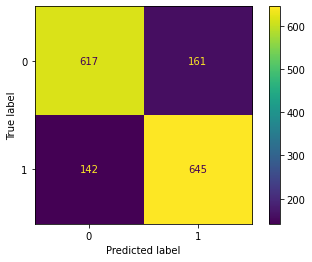

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       778
           1       0.80      0.82      0.81       787

    accuracy                           0.81      1565
   macro avg       0.81      0.81      0.81      1565
weighted avg       0.81      0.81      0.81      1565



In [ ]:
MLP = MLPClassifier(**best_mlp).fit(x_train, y_train)

train_predictions = MLP.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train MLP: %.2f%%" % (accuracy * 100.0))

test_predictions = MLP.predict(x_test)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test MLP: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

print(classification_report(y_test, MLP.predict(x_test)))

###Modelo 3: Ajuste de hiperparámetros: GBC (la prueba con todos los hiperparametros que usamos tardaba mas de 2 hs en correr pero es el que nos dió mejor y el que subimos a Kaagle y logro el 9no lugar). Aclaración: las métricas van cambiando cada vez que corremos el modelo, la que se muestra es la mas parecida a la que obtuvimos en la corrida original que subimos a kaggle sin embargo, el csv que se descarga no es identico al que subimos al kaggle y saco nuestro mayor puntaje en la competencia. 

In [ ]:
GBC = GradientBoostingClassifier().fit(x_train, y_train)

In [ ]:
param_grid_gbc = {"loss":["deviance"], 
    "learning_rate": [0.1],
    "n_estimators": [100],
    "min_samples_split": [4],
    "min_samples_leaf": [1],
    "max_depth":[5],
    "max_features":["log2"],
  "criterion": ["squared_error"],

                }
modelo =GradientBoostingClassifier().fit(x_train, y_train)
grid = GridSearchCV(modelo, param_grid_gbc)
grid.fit(x_train,y_train)
grid.best_params_



{'criterion': 'squared_error',
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}

Accuracy train GBC: 85.65%
Accuracy test GBC: 81.47%


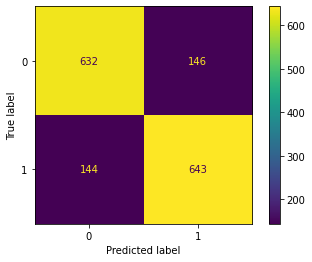

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       778
           1       0.81      0.82      0.82       787

    accuracy                           0.81      1565
   macro avg       0.81      0.81      0.81      1565
weighted avg       0.81      0.81      0.81      1565



In [ ]:
GBC = GradientBoostingClassifier(**grid.best_params_).fit(x_train, y_train)

train_predictions = GBC.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train GBC: %.2f%%" % (accuracy * 100.0))

test_predictions = GBC.predict(x_test)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test GBC: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

print(classification_report(y_test,GBC.predict(x_test)))

##Predicción y salida para entregar

In [ ]:
val_df = read_csv_from_drive(drive, '1AJdQMmzxrXhocEX4ZQhDoIWXRRaesA80' , 'test.csv')

In [ ]:
print(val_df.shape)
val_df.head(5)

(870, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,415,Europa,True,NaN,55 Cancri e,34.0,False,0.0,0.0,0.0,0.0,0.0,Minopus Taptiritty
1,8663,Earth,True,G/1489/S,PSO J318.5-22,13.0,False,0.0,0.0,0.0,0.0,0.0,Chrisa Francock
2,4524,Earth,False,G/776/P,TRAPPIST-1e,44.0,False,22.0,1.0,0.0,864.0,0.0,Elinda Miley
3,8246,Earth,False,E/577/S,PSO J318.5-22,63.0,False,0.0,0.0,80.0,0.0,2322.0,Karley Goods
4,2935,Europa,False,B/117/S,55 Cancri e,10.0,False,0.0,0.0,0.0,0.0,0.0,Arkard Sechausive


###Tratamiento del conjunto de datos

In [ ]:
#PassengerId saving
PassengerId = val_df['PassengerId']

#Saco la variable "Name" que entiendo no aporta información relevante
val_df1= val_df.drop('Name', axis=1)

# Imputo valores en todas las variables
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService", "HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP" ]
imputer = SimpleImputer(strategy="most_frequent")
val_df1[imputer_cols] = imputer.fit_transform(val_df1[imputer_cols])

#Creacion de 3 columnas a partir de la columna cabin
val_df1[['cabin_deck','cabin_num','cabin_side']] = val_df1['Cabin'].str.split('/', expand=True)

##Sacamos la variable Cabin Original
val_df1=val_df1.drop('Cabin',axis=1)

#Codifico en binarias a las variables
val_df_dummies = pd.get_dummies(val_df1[['CryoSleep', 'VIP', 'cabin_deck', 'cabin_side','HomePlanet', 'Destination']], prefix=['CryoSleep', 'VIP', 'cabin_deck', 'cabin_side',
            'HomePlanet', 'Destination'], prefix_sep='_', dummy_na=False, sparse=False)
dummies_cols = list(val_df_dummies.columns)

#Agrega las columnas de los encodings al df original, y se quitan las categóricas
val_df2 = pd.concat([val_df1,val_df_dummies], axis=1)
val_df2 = val_df2.drop(['HomePlanet','CryoSleep','VIP','Destination', 'cabin_deck', 'cabin_side'], axis=1)

# Escalo los datos
scaler = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
val_df2_to_scld = val_df2.copy(deep=True)
val_df2_scld = scaler.fit_transform(val_df2_to_scld)
val_df2_scld = pd.DataFrame(val_df2_scld, columns=val_df2_to_scld.columns)




###Predicciones

In [ ]:
val_id = PassengerId

 #Modelo 1
val_pred_1 = RDF.predict(val_df2_scld)

 #Modelo 2
val_pred_2 = MLP.predict(val_df2_scld)

 #Modelo 3
val_pred_3 = GBC.predict(val_df2_scld)

###Generación de archivos de salida

In [ ]:
from google.colab import files

In [ ]:
submission1 = pd.DataFrame(list(zip(val_id, val_pred_1)), columns=["PassengerId", "Transported"])
submission1.to_csv("submission_modelo1.csv", header=True, index=False)
files.download("submission_modelo1.csv")

submission2 = pd.DataFrame(list(zip(val_id, val_pred_2)), columns=["PassengerId", "Transported"])
submission2.to_csv("submission_modelo2.csv", header=True, index=False)
files.download("submission_modelo2.csv")

submission3 = pd.DataFrame(list(zip(val_id, val_pred_3)), columns=["PassengerId", "Transported"])
submission3.to_csv("submission_modelo3.csv", header=True, index=False)
files.download("submission_modelo3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>